In [38]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
import hist
import numpy as np
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
# sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # from ABCD_study notebook
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm

def addStats(H):
    ''' This adds a Statistics box for the histogram that is passed. It shows count, mean, and STD. '''
    stats = (np.atleast_1d(H.profile(axis=0).view())[0])
    count , mean , sumDeltaSquared = int(stats['count']), stats['value'], stats['_sum_of_deltas_squared']
    std = np.sqrt(sumDeltaSquared/count)
    statbox = '' +f'{"Entries:":<{10}}{count:d}' + '\n' + f'{"Mean:":<{10}}{mean:.3f}' + '\n' + f'{"Std Dev:":<{10}}{std:.3f}'
    return statbox

In [2]:
client = scaleout.make_dask_client("tls://192.168.161.179:8786")
client

Connection method: Direct,
Dashboard: /user/john.david.m@cern.ch/proxy/8787/status,
Comm: tls://192.168.161.179:8786,Workers: 0
Dashboard: /user/john.david.m@cern.ch/proxy/8787/status,Total threads: 0
Started: 2 minutes ago,Total memory: 0 B


In [3]:
samples_2mu2e = [
    "2Mu2E_500GeV_5p0GeV_0p8mm",
    "2Mu2E_500GeV_5p0GeV_8p0mm"
]

samples_4mu = [
    "4Mu_500GeV_0p25GeV_0p004mm",
    "4Mu_500GeV_0p25GeV_0p04mm",
    "4Mu_500GeV_0p25GeV_0p4mm",
    "4Mu_500GeV_0p25GeV_2p0mm",
    "4Mu_500GeV_0p25GeV_4p0mm",
    
    "4Mu_500GeV_1p2GeV_0p019mm",
    "4Mu_500GeV_1p2GeV_0p19mm",
    "4Mu_500GeV_1p2GeV_1p9mm",
    "4Mu_500GeV_1p2GeV_9p6mm",
    "4Mu_500GeV_1p2GeV_19p0mm",
    
    "4Mu_500GeV_5p0GeV_0p08mm",
    "4Mu_500GeV_5p0GeV_0p8mm",
    "4Mu_500GeV_5p0GeV_8p0mm",
    "4Mu_500GeV_5p0GeV_40p0mm",
    "4Mu_500GeV_5p0GeV_80p0mm",
]

samples_bkg = [
    "TTJets",
]

In [4]:
#fileset_2mu2e = utilities.make_fileset(samples_2mu2e, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")
fileset_4mu = utilities.make_fileset(samples_4mu, "llpNanoAOD_v2", max_files=1, location_cfg="signal_4mu_v10.yaml")
#fileset_bkg = utilities.make_fileset(samples_bkg, "skimmed_llpNanoAOD_v2", max_files=-1, location_cfg="backgrounds.yaml")

# fileset_2mu2e['4Mu_500GeV_5p0GeV_0p08mm'] = fileset_4mu['4Mu_500GeV_5p0GeV_0p08mm']
# fileset_2mu2e['TTJets'] = fileset_bkg['TTJets']

runner = processor.Runner(
    #executor=processor.DaskExecutor(client=client),
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(), 
    schema=NanoAODSchema,
    maxchunks=1, 
    skipbadfiles=True
)

channels = [
    "base",
    #"baseNoLjNoLjsource",
    "jake_test_select",
    #"baseNoLj",
    #"2mu2e",
    "4mu",
]

p = sidm_processor.SidmProcessor(
    channels,
    #["dsaMuon_base", 'muon_base',"lj_lj_base", "jake_test_collection"], #hist_collections.py
    ['muon_base', "jake_test_collection"], #hist_collections.py
    #lj_reco_choices=["0.4"],
    #unweighted_hist=True,
)

output = runner.run(fileset_4mu, treename="Events", processor_instance=p)
out = output["out"]

# bkg_output = runner.run(fileset_2mu2e, treename="Events", processor_instance=p)
# bkg_out = bkg_output["out"]


Output()

Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb


## Checking Output Form
Checking all of the available options that are in the output variable of the Runner. 

1. Specify the sample that you wish to analyze from the runner. out["sample"]
2. The options are
    * cutflow
        * base
            * Cutflow object
    * hists
        * See next cell
        * Basically a dictionary of various Hist objects. These Hist objects can then be used with the utilities.plot() command to actually make the histograms. A channel still needs to be specified (like 'base'). Then, the plotting function requires the slicing to be like [channels[i], :]. I think the channel should match the StrCategory() parameter of the Hist object. 
    * counters
        * See cell
    * metadata
        * {'n_evts': 4295}

### cutflow
out[sample]['cutflow'][all channels specified above] -> cutflow instance

In [ ]:
sample = samples_2mu2e[0]
# sample = 
for entry in out[sample]['cutflow']:
    print(entry)
    print()
    print("Efficiency: ", out[sample]['cutflow'][entry].efficiency())
    print(out[sample]['cutflow'][entry].print_table())
    # print(out[sample]['hists'])
    print('--------------------------------------------------------------------------------------------------------------------------')

### hists
<u><b>Dictionary with the following entries:</u></b>

* 'dsaMuon_n': Hist( StrCategory(['base'], name='channel'), Regular(10, 0, 10, name='dsaMuons_n', label='Number of DSA Muons'), storage=Weight()) # Sum: WeightedSum(value=1591, variance=1591), 

* 'dsaMuon_pt': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 500, name='dsaMuons_pt', label='DSA Muon $p_T$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=5, variance=5), 

* 'dsaMuon_dxy': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 100, name='dsaMuons_dxy', label='DSA Muon $d_0$'), storage=Weight()) # Sum: WeightedSum(value=1, variance=1) (WeightedSum(value=5, variance=5) with flow), 

* 'dsaMuon_eta_phi': Hist( StrCategory(['base'], name='channel'), Regular(50, -3, 3, name='dsaMuons_eta', label='DSA Muon $\\eta$'), Regular(50, -3.14159, 3.14159, name='dsaMuons_phi', label='DSA Muon $\\phi$'), storage=Weight()) # Sum: WeightedSum(value=5, variance=5), 

* 'dsaMuon_absD0': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 500, name='dsaMuons_dxy', label='DSA Muon |$d_0$|'), storage=Weight()) # Sum: WeightedSum(value=5, variance=5), 

* 'dsaMuon_absD0_lowRange': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 10, name='dsaMuons_dxy', label='DSA Muon |$d_0$|'), storage=Weight()) # Sum: WeightedSum(value=3, variance=3) (WeightedSum(value=5, variance=5) with flow), 

* 'muon_n': Hist( StrCategory(['base'], name='channel'), Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'), storage=Weight()) # Sum: WeightedSum(value=1591, variance=1591), 

* 'muon_pt': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=3240, variance=3240), 

* 'muon_dxy': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'), storage=Weight()) # Sum: WeightedSum(value=1613, variance=1613) (WeightedSum(value=3240, variance=3240) with flow), 

* 'muon_eta_phi': Hist( StrCategory(['base'], name='channel'), Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'), Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'), storage=Weight()) # Sum: WeightedSum(value=3240, variance=3240), 

* 'muon_absD0': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 500, name='muons_dxy', label='PF Muon |$d_0$|'), storage=Weight()) # Sum: WeightedSum(value=3240, variance=3240), 

* 'muon_absD0_lowRange': Hist( StrCategory(['base'], name='channel'), Regular(100, 0, 10, name='muons_dxy', label='PF Muon |$d_0$|'), storage=Weight()) # Sum: WeightedSum(value=3240, variance=3240)
}

### counters
<u><b>Dictionary with the following entry(ies):</u></b>

* {'0.4':
    * {'base': {
        * 'Total LJs': 3190,
        * 'Gen As to muons': 1591,
        * 'Gen As to electrons': 1591,
        * 'Matched gen As to muons': 1591,
        * 'Matched gen As to electrons': 1591}}}

### Testing Code

In [18]:
sample = "4Mu_500GeV_0p25GeV_0p004mm"
# sample = 
# for entry in out[sample]['hists']:
#     print(entry)
#     print()
#     print(out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :])
#     # print(out[sample]['hists'])
#     print('--------------------------------------------------------------------------------------------------------------------------')
for sample in samples_4mu:
    print(sample)
    print()
    # print(hist.sum)
    print(type(out[sample]["hists"]["muon_n"][channels[1], :]))
    
    values = out[sample]["hists"]["muon_n"][channels[1], :].values()
    print("Values: ", values, "\n")

    centers = out[sample]["hists"]["muon_n"][channels[1], :].axes[0].centers
    print("Bin Centers", centers, '\n')
    
    histSum = out[sample]["hists"]["muon_n"][channels[1], :].sum().value
    print("Sum of Values: ", histSum)

    # Calculate the weighted average
    sum_of_values = np.sum(values * centers)
    total_count = np.sum(values)
    probs = values / total_count
    average = sum_of_values / total_count
    print("Average: ", average)

    # Calculate the standard deviation
    std_dev = np.sqrt(np.sum(probs * (centers - average)**2))
    var = np.average((centers - average)**2, weights=values)
    print("Std_Dev: ", std_dev)
    print("Variance: ", var)
    
    print("\n\n\n")
    print(out[sample]["hists"]["muon_n"][channels[1], :].profile(0))
    print(out[sample]["hists"]["muon_n"][channels[1], :].profile(0).sum().variance)
    
    print("\n\n\n")
    H=out[sample]["hists"]["muon_n"][channels[1], :]
    stats = (np.atleast_1d(H.profile(axis=0).view())[0])
    print("STATS", type(stats))
    count , mean , sumDeltaSquared = int(stats['count']), stats['value'], stats['_sum_of_deltas_squared']
    std = np.sqrt(sumDeltaSquared/count)
    print("Sum Delta Squared", sumDeltaSquared)
    print("STD:", std)
    
    print('--------------------------------------------------------------------------------------------------------------------------')
    break
print(out[sample]["hists"]["muon_n"][channels[1], :])
print(out[sample]["hists"]["muon_n"][channels[1], :].variances().sum())

4Mu_500GeV_0p25GeV_0p004mm

<class 'hist.hist.Hist'>
Values:  [ 0.          0.          0.0429094   1.10134114 18.88013388  0.70085345
  0.          0.          0.          0.        ] 

Bin Centers [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5] 

Sum of Values:  20.725237867559166
Average:  4.476535541752933
Std_Dev:  0.3077133640862335
Variance:  0.0946875144372669




Hist(storage=Mean()) # Sum: Mean(count=20.7252, value=4.47654, variance=0.00135433)
0.0013543279915806576




STATS <class 'boost_histogram.accumulators.Mean'>
Sum Delta Squared 0.02671444178462214
STD: 0.0365475319170954
--------------------------------------------------------------------------------------------------------------------------
                    ┌────────────────────────────────────────────────────────┐
[-inf,   0) 0       │                                                        │
[   0,   1) 0       │                                                        │
[   1,   2) 0       │                            

## LJ_LJ_Mass_Diff Sample Matrix
A plot of the difference in mass between the two lepton jets. Presented as a matrix of different samples with different bound state masses and lxy. 

### Matrix Plot

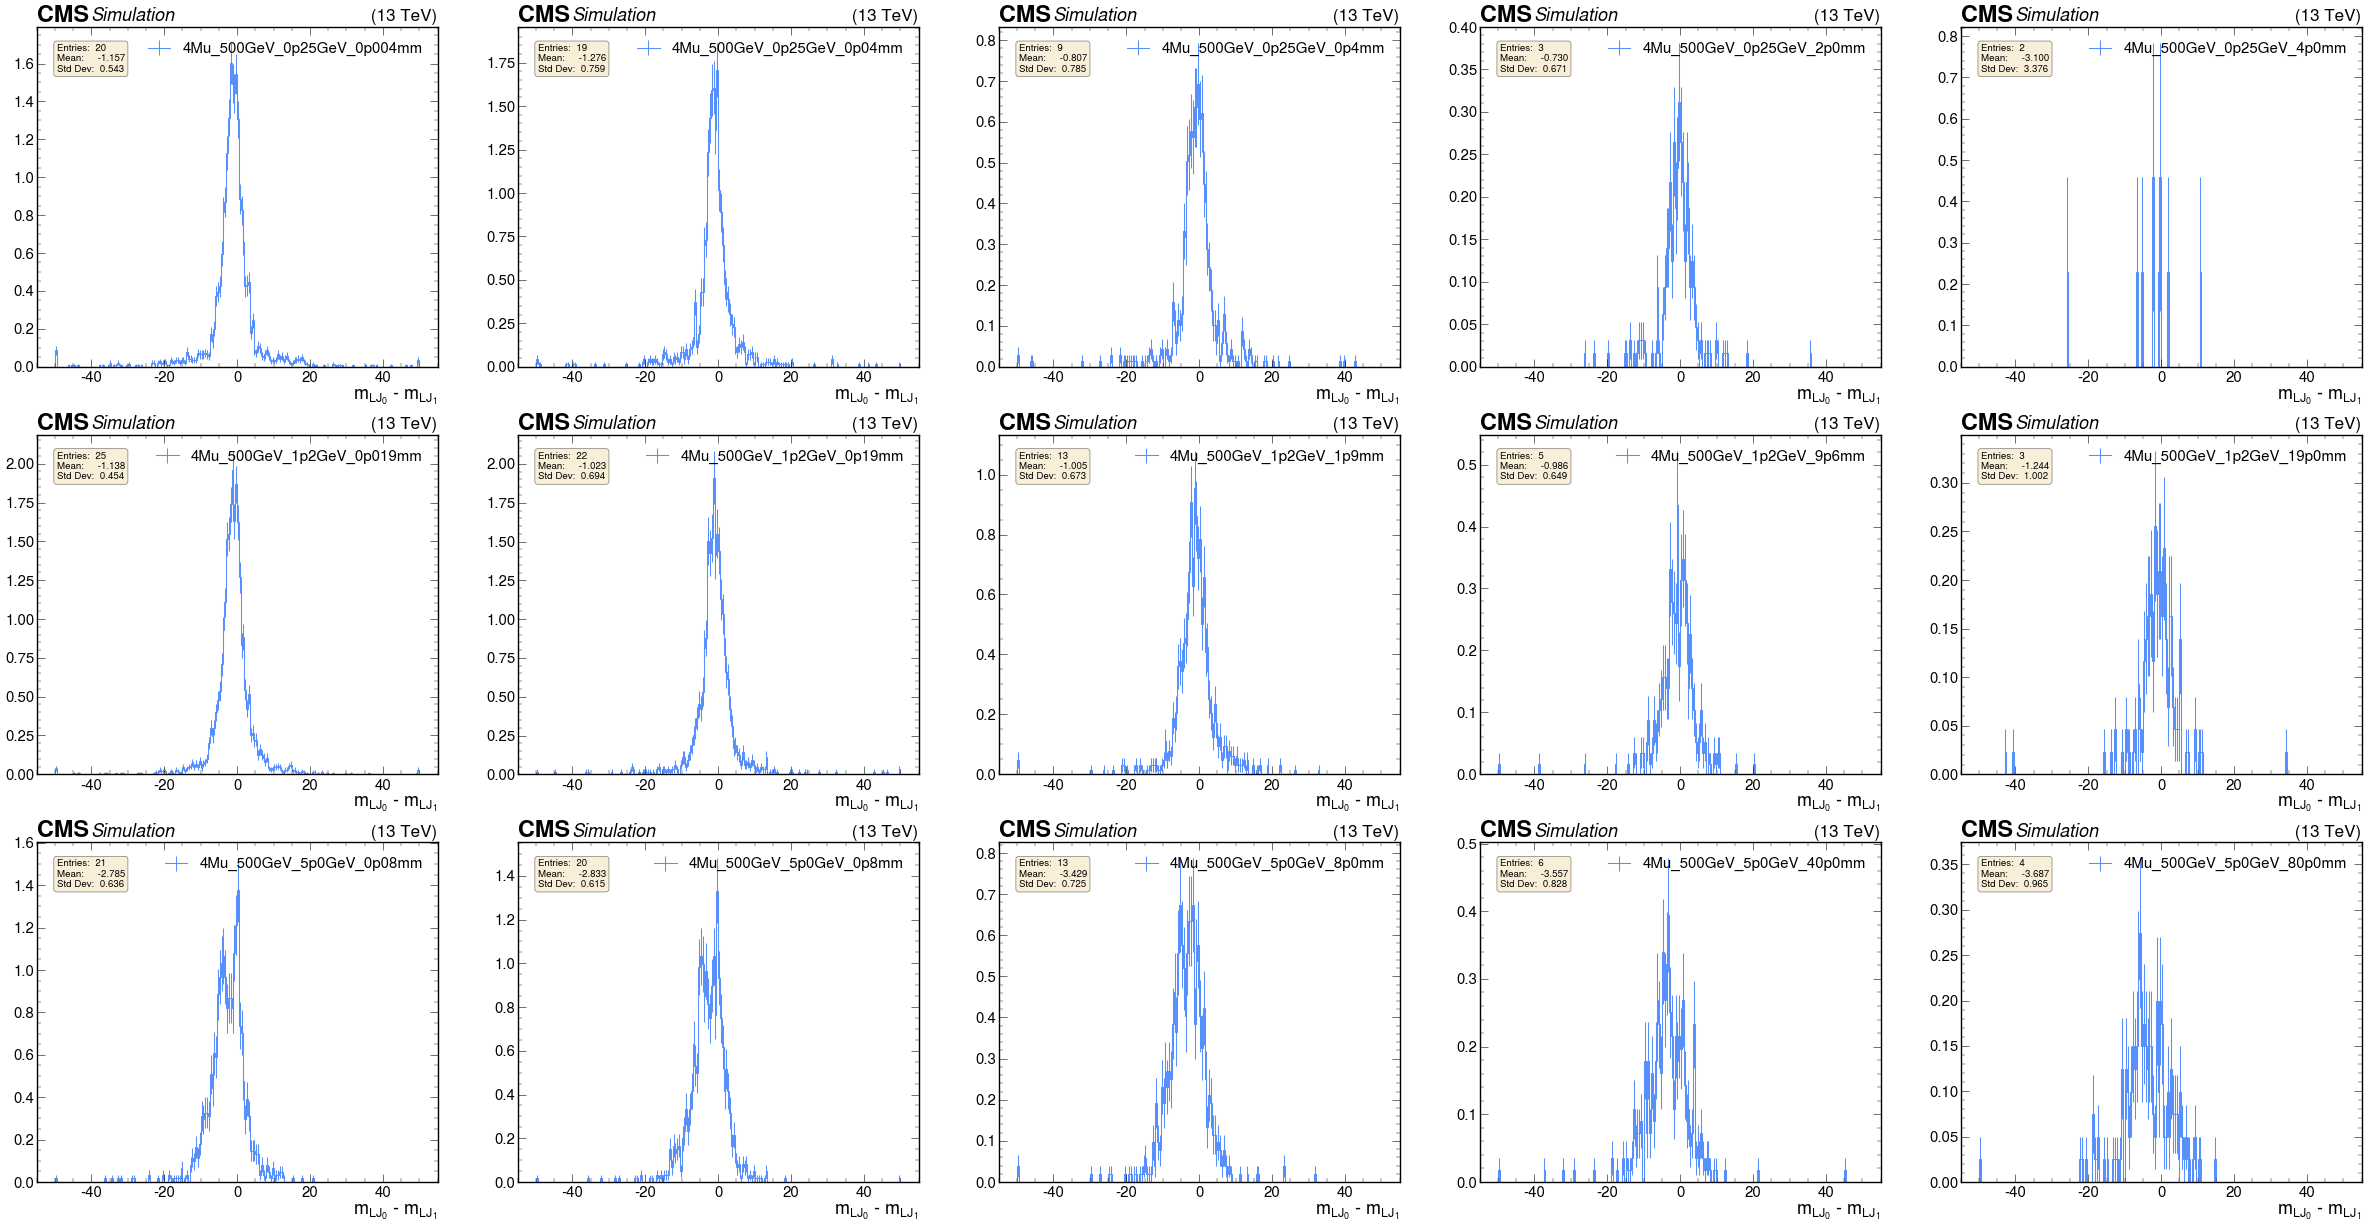

In [51]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows,ncols,figsize=(12*ncols,10*nrows))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for index, sample in enumerate(samples_4mu):
    row = int(index / ncols)
    col = index % ncols

    # print(f"Index: {index} \n Row: {row} \n Col: {col} \n")
    
    #print(f"Sample: {sample}\tIndex: {index}")
    # plt.subplot(row,5,index+1)
    plt.subplot(3,5,index+1)
    # utilities.plot(out[sample]["hists"]["muon_n"][channels[1], :], density=False, label=sample)
    hist = out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :]
    utilities.plot(hist, density=False, label=sample)
    textBox = addStats(hist)
    axes[row, col].text(0.05, 0.95, textBox, transform=axes[row, col].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    plt.legend()

Entries:  20
Mean:     -1.157
Std Dev:  0.543
Entries:  19
Mean:     -1.276
Std Dev:  0.759
Entries:  9
Mean:     -0.807
Std Dev:  0.785
Entries:  3
Mean:     -0.730
Std Dev:  0.671
Entries:  2
Mean:     -3.100
Std Dev:  3.376
Entries:  25
Mean:     -1.138
Std Dev:  0.454
Entries:  22
Mean:     -1.023
Std Dev:  0.694
Entries:  13
Mean:     -1.005
Std Dev:  0.673
Entries:  5
Mean:     -0.986
Std Dev:  0.649
Entries:  3
Mean:     -1.244
Std Dev:  1.002
Entries:  21
Mean:     -2.785
Std Dev:  0.636
Entries:  20
Mean:     -2.833
Std Dev:  0.615
Entries:  13
Mean:     -3.429
Std Dev:  0.725
Entries:  6
Mean:     -3.557
Std Dev:  0.828
Entries:  4
Mean:     -3.687
Std Dev:  0.965


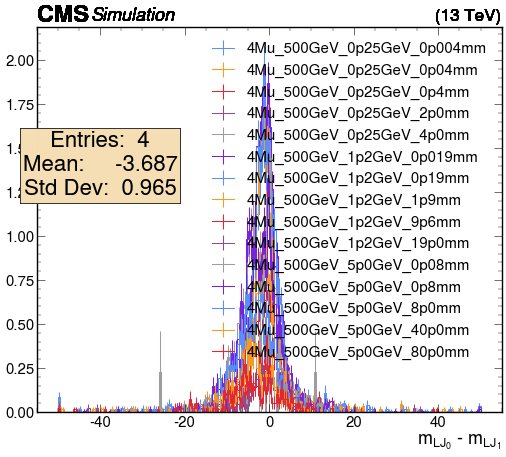

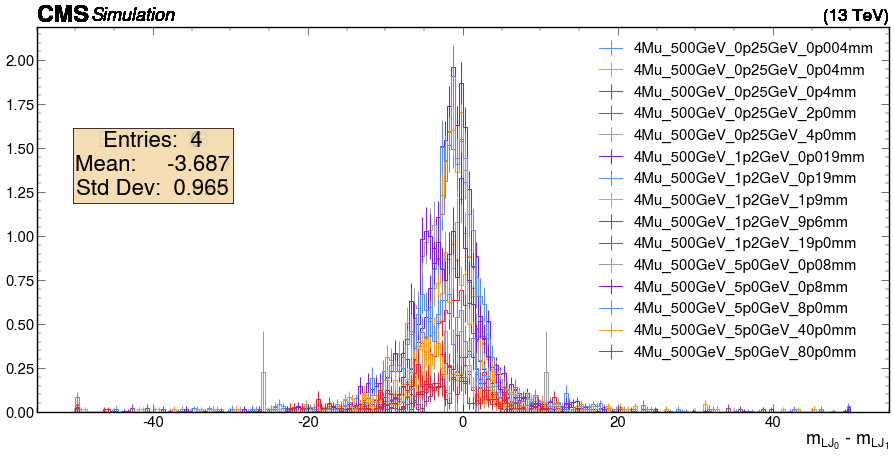

In [43]:
plt.subplots(1,1,figsize=(12,10))
for index, sample in enumerate(samples_4mu):
    # plt.subplot(1,1,1)
    # utilities.plot(out[sample]["hists"]["muon_n"][channels[1], :], density=False, label=sample)
    utilities.plot(out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :], density=False, label=sample)
    statbox = addStats(H)
    plt.text(-40, 1.6, statbox, fontsize=32, verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='wheat', alpha=0.8))

    plt.legend()

plt.subplots(1,1,figsize=(22,10))
for index, sample in enumerate(samples_4mu):
    H=out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :]
    stats = (np.atleast_1d(H.profile(axis=0).view())[0])
    # print("STATS", type(stats))
    count , mean , sumDeltaSquared = int(stats['count']), stats['value'], stats['_sum_of_deltas_squared']
    std = np.sqrt(sumDeltaSquared/count)
    # print("Sum Delta Squared", sumDeltaSquared)
    #print(sample, "\nMean:", mean, "\t", "STD:", std, "\n")
    statbox = addStats(H)
    print(statbox)
    
    utilities.plot(out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :], density=False, label=sample)
    plt.text(-40, 1.6, statbox, fontsize=32, verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='wheat', alpha=0.8))

    plt.legend()

## Plotting Code

In [ ]:
plt.subplots(1,3,figsize=(36,10))


for sample in samples_2mu2e:
    plt.subplot(1,3,1)
    # utilities.plot(out["2Mu2E_500GeV_5p0GeV_0p08mm"]["hists"]["matched_jet_pt"][channels[0], :], density=False, label="2Mu2E")
    # utilities.plot(out[sample]["hists"]["dsaMuon_pt"][channels[0], :], density=False, label="dsa 2Mu2E")
    # utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :], density=False, label="pf 2Mu2E")
    #utilities.plot(out[sample]["hists"]["jake_test_no_mask"][channels[1], :], density=False, label="2E Inv Mass No Mask")
    
    utilities.plot(out[sample]["hists"]["jake_test"][channels[1], :], density=False, label=sample)
    plt.legend()
    print(sample)
    
    plt.subplot(1,3,3)
    utilities.plot(out[sample]["hists"]["lj_lj_mass_diff"][channels[1], :], density=False, label=sample)
    plt.legend()

### To Be Looked At

In [ ]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples_4mu:
    utilities.plot(out["4Mu_500GeV_5p0GeV_0p08mm"]["hists"]["matched_jet_pt"][channels[0], :], density=False, label="4Mu", color="orange")
plt.legend()

plt.subplot(1,3,2)
for sample in samples_4mu:
    utilities.plot(out["4Mu_500GeV_5p0GeV_0p08mm"]["hists"]["lj_isolation"][channels[0], :], density=False, label="4Mu", color="orange")
plt.legend()

plt.subplot(1,3,3)
for sample in samples_4mu:
    utilities.plot(out["4Mu_500GeV_5p0GeV_0p08mm"]["hists"]["matched_jet_lj_dR"][channels[0], :], density=False, label="4Mu", color="orange")
plt.legend()

In [ ]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples_bkg:
    utilities.plot(out["TTJets"]["hists"]["matched_jet_pt"][channels[0], :], density=False, label="TTJets", color="green")
plt.legend()

plt.subplot(1,3,2)
for sample in samples_bkg:
    utilities.plot(out["TTJets"]["hists"]["lj_isolation"][channels[0], :], density=False, label="TTJets", color="green")
plt.legend()

plt.subplot(1,3,3)
for sample in samples_bkg:
    utilities.plot(out["TTJets"]["hists"]["matched_jet_lj_dR"][channels[0], :], density=False, label="TTJets", color="green")
plt.legend()

In [ ]:
samples_all = [
    "2Mu2E_500GeV_5p0GeV_0p08mm",
    "4Mu_500GeV_5p0GeV_0p08mm",
    "TTJets",
]

In [ ]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples_all:
    utilities.plot(out[sample]["hists"]["matched_jet_pt"][channels[0], :], density=False)
plt.legend(samples_all, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,3,2)
for sample in samples_all:
    utilities.plot(out[sample]["hists"]["lj_isolation"][channels[0], :], density=False)
plt.legend(samples_all, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,3,3)
for sample in samples_all:
    utilities.plot(out[sample]["hists"]["matched_jet_lj_dR"][channels[0], :], density=False)
plt.legend(samples_all, loc=1, prop={'size': 18})
plt.yscale("log")

In [ ]:

# plt.subplot(1,3,2)
# utilities.plot(bkg_out[sample]["hists"]["jake_test"][channels[1], :], density=False, label="TTJets")
# plt.legend();

# plt.subplot(1,3,2)
# for sample in samples_2mu2e:
#     utilities.plot(out["2Mu2E_500GeV_5p0GeV_0p08mm"]["hists"]["lj_isolation"][channels[0], :], density=False, label="2Mu2E")
# plt.legend()

# plt.subplot(1,3,3)
# for sample in samples_2mu2e:
#     utilities.plot(out["2Mu2E_500GeV_5p0GeV_0p08mm"]["hists"]["matched_jet_lj_dR"][channels[0], :], density=False, label="2Mu2E")
# plt.legend()